In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import datetime as dt
import geopandas as gpd
from shapely.geometry import Point, LineString,MultiLineString,Polygon
from shapely import ops
import matplotlib.pyplot as plt
%matplotlib inline
import os
import folium
attr='(c) <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors (c) <a href="http://cartodb.com/attributions">CartoDB</a>, CartoDB <a href ="http://cartodb.com/attributions">attributions</a>'
from selenium import webdriver
import PIL
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import glob
import moviepy.editor as mpy
from flask import request

In [2]:
# Define the API endpoint
url = "https://data.traffic.hereapi.com/v7/flow"

# Define the query parameters
params = {
    "locationReferencing": "shape",
    #"in": "bbox:107.54908372065572,-6.926620456605005,107.72967148820469,-6.896286771555365",
    "in": "bbox:107.2510292754,-7.3097642655,107.9384321719,-6.8128449268",
    "apiKey": "z1hUE5rH83_F6uIgubqDkRHn6JQK8s5tUa106Nudp6c",
    "responseattributes": "sh,fc"
}


In [3]:
"https://traffic.api.here.com/traffic/6.3/flow.json?bbox=-6.926620456605005,107.54908372065572;-6.896286771555365,107.72967148820469&apiKey=Cdfx4rTgJqyfEJv1ydzReBDhwqpkx1PymIp4UjaYWvc&responseattributes=sh,fc"

'https://traffic.api.here.com/traffic/6.3/flow.json?bbox=-6.926620456605005,107.54908372065572;-6.896286771555365,107.72967148820469&apiKey=Cdfx4rTgJqyfEJv1ydzReBDhwqpkx1PymIp4UjaYWvc&responseattributes=sh,fc'

In [8]:
from shapely.geometry import Point, LineString
import geopandas as gpd

with open('2023-03-26 22-01-30.json', 'r') as f:
    data = json.load(f)

rows = []
for result in data['results']:
    location = result['location']
    description = location['description']
    length = location['length']
    links = location['shape']['links']
    latitudes = []
    longitudes = []
    for link in links:
        if 'points' in link:
            for point in link['points']:
                latitudes.append(point['lat'])
                longitudes.append(point['lng'])
    speed = result['currentFlow']['speed']
    freeflow = result['currentFlow']['freeFlow']
    jamfactor = result['currentFlow']['jamFactor']
    rows.append([description, length, latitudes, longitudes, speed, freeflow, jamfactor])

df = pd.DataFrame(rows, columns=['Description', 'Length', 'Latitudes', 'Longitudes', 'Speed', 'FreeFlow', 'JamFactor'])



In [9]:
df

,Description,Length,Latitudes,Longitudes,Speed,FreeFlow,JamFactor
0,Jalan Karacak,648.0,"[-7.216099966317415, -7.216489976271987, -7.21...","[107.90891001932323, 107.90878001600504, 107.9...",7.222222,7.222222,0.0
1,Jalan Karacak,632.0,"[-7.226889990270138, -7.226020032539964, -7.22...","[107.91117003187537, 107.91111001744866, 107.9...",7.777778,8.055555,0.3
2,Jalan Jendral Sudirman,243.0,"[-7.190529964864254, -7.1907000336796045, -7.1...","[107.90281997993588, 107.9029400087893, 107.90...",6.111111,6.388889,0.3
3,Jalan Pembangunan/Jalan Patriot/Jalan Terusan ...,862.0,"[-7.192649999633431, -7.193799996748567, -7.19...","[107.88660996593535, 107.88656000979245, 107.8...",8.055555,8.888889,0.2
4,Jalan KH Hasan Arif/Jalan Mayor Suherman,86.0,"[-7.189999977126718, -7.189999977126718, -7.19...","[107.90267002768815, 107.90280003100634, 107.9...",5.833334,6.111111,0.3
...,...,...,...,...,...,...,...
3336,Kabupaten Bandung 1,1206.0,"[-6.961560007184744, -6.961499992758036, -6.96...","[107.54578996449709, 107.54577999003232, 107.5...",5.277778,5.277778,0.0
3337,Jalan Raya Rancapanggung,64.0,"[-6.980639984831214, -6.980140004307032]","[107.42891002446413, 107.42862998507917]",4.722222,4.722222,0.0
3338,Cilamenta,100.0,"[-6.928990026935935, -6.929179960861802, -6.92...","[107.50270999968052, 107.50300001353025, 107.5...",9.166667,9.444445,0.2
3339,Citamiang,2551.0,"[-6.973849972710013, -6.974020041525364, -6.97...","[107.61739002540708, 107.61697000823915, 107.6...",7.222222,7.500000,0.2


In [10]:
geometry = [LineString(list(zip(row['Longitudes'], row['Latitudes']))) for _, row in df.iterrows()]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.crs = {'init':'epsg:4326'}


In [11]:
gdf.head()

,Description,Length,Latitudes,Longitudes,Speed,FreeFlow,JamFactor,geometry
0,Jalan Karacak,648.0,"[-7.216099966317415, -7.216489976271987, -7.21...","[107.90891001932323, 107.90878001600504, 107.9...",7.222222,7.222222,0.0,"LINESTRING (107.90891 -7.21610, 107.90878 -7.2..."
1,Jalan Karacak,632.0,"[-7.226889990270138, -7.226020032539964, -7.22...","[107.91117003187537, 107.91111001744866, 107.9...",7.777778,8.055555,0.3,"LINESTRING (107.91117 -7.22689, 107.91111 -7.2..."
2,Jalan Jendral Sudirman,243.0,"[-7.190529964864254, -7.1907000336796045, -7.1...","[107.90281997993588, 107.9029400087893, 107.90...",6.111111,6.388889,0.3,"LINESTRING (107.90282 -7.19053, 107.90294 -7.1..."
3,Jalan Pembangunan/Jalan Patriot/Jalan Terusan ...,862.0,"[-7.192649999633431, -7.193799996748567, -7.19...","[107.88660996593535, 107.88656000979245, 107.8...",8.055555,8.888889,0.2,"LINESTRING (107.88661 -7.19265, 107.88656 -7.1..."
4,Jalan KH Hasan Arif/Jalan Mayor Suherman,86.0,"[-7.189999977126718, -7.189999977126718, -7.19...","[107.90267002768815, 107.90280003100634, 107.9...",5.833334,6.111111,0.3,"LINESTRING (107.90267 -7.19000, 107.90280 -7.1..."


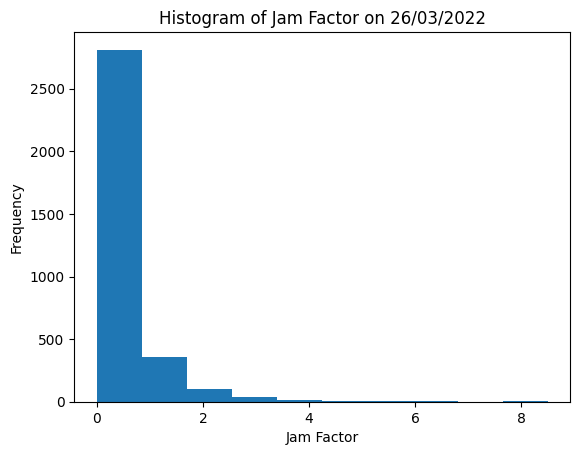

In [12]:
import matplotlib.pyplot as plt

# Create a histogram plot
plt.hist(df['JamFactor'], bins=10)

# Set the title and labels
plt.title('Histogram of Jam Factor on 26/03/2022')
plt.xlabel('Jam Factor')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [13]:
bin_edges = [-1, 1, 3, 4, 8, 11]

# use pd.cut to categorize the 'jamFactor' column
df['jamFactor_category'] = pd.cut(df['JamFactor'], bins=bin_edges)

df['group'] = df['jamFactor_category']
# print the count of observations in each category
print(df['group'].value_counts())

(-1, 1]    2976
(1, 3]      321
(3, 4]       29
(4, 8]       13
(8, 11]       2
Name: group, dtype: int64


<Axes: >

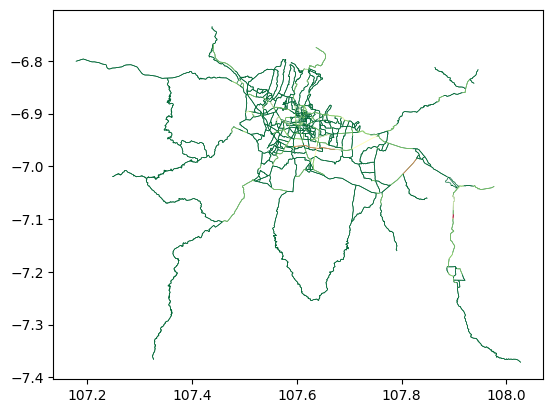

In [14]:
gdf.sort_values("JamFactor").plot(column="group", cmap='RdYlGn_r', categorical=True, linewidth=.5)